# ISPR Midterm 1 - Assignment 4
# Alessandro Trenta - 566072

Here we load the dataset and unzip it.

In [ ]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip /content/msrc_objcategimagedatabase_v1.zip

--2022-03-09 11:04:58--  http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.106.8.114, 2600:1408:5400:38d::e59, 2600:1408:5400:38b::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.106.8.114|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip [following]
--2022-03-09 11:04:58--  https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Connecting to download.microsoft.com (download.microsoft.com)|104.106.8.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip’

msrc_objcategimaged 100%[===================>]  42.08M  1

Import the necessary libraries

In [ ]:
import os
from scipy import misc
import imageio
import numpy as np
from matplotlib import pyplot as plt
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
import glob
import cv2 as cv

Here we import some example images (one for each thematic subset) to set the parameters we like the most.

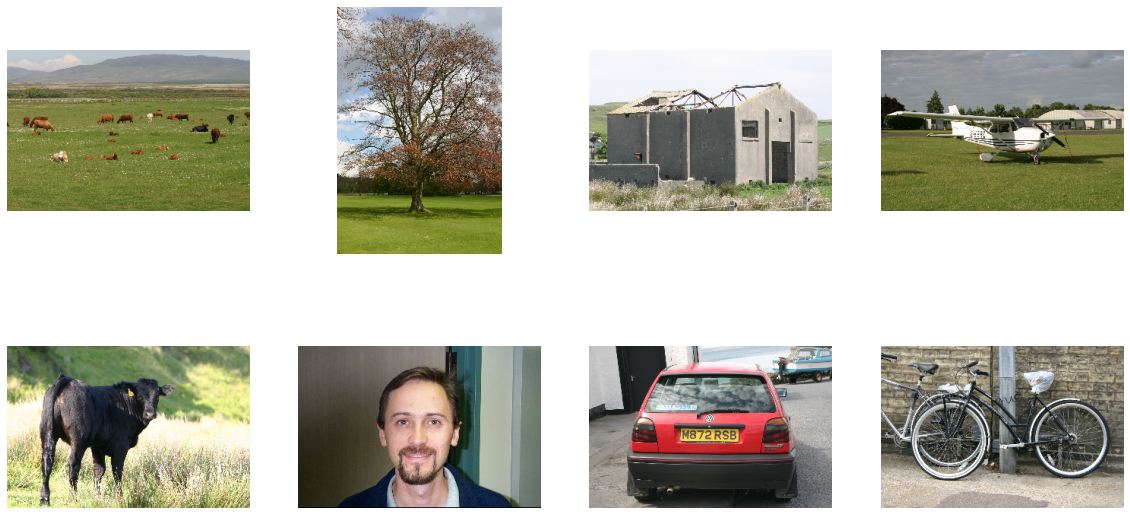

In [ ]:
path = '/content/MSRC_ObjCategImageDatabase_v1'
image1 = imageio.imread(os.path.join(path,'1_10_s.bmp'))
image2 = imageio.imread(os.path.join(path,'2_10_s.bmp'))
image3 = imageio.imread(os.path.join(path,'3_10_s.bmp'))
image4 = imageio.imread(os.path.join(path,'4_10_s.bmp'))
image5 = imageio.imread(os.path.join(path,'5_10_s.bmp'))
image6 = imageio.imread(os.path.join(path,'6_10_s.bmp'))
image7 = imageio.imread(os.path.join(path,'7_10_s.bmp'))
image8 = imageio.imread(os.path.join(path,'8_10_s.bmp'))

F, ax = plt.subplots(2,4, figsize=(20,10))
ax[0,0].imshow(image1)
ax[0,0].axis('off')
ax[0,1].imshow(image2)
ax[0,1].axis('off')
ax[0,2].imshow(image3)
ax[0,2].axis('off')
ax[0,3].imshow(image4)
ax[0,3].axis('off')
ax[1,0].imshow(image5)
ax[1,0].axis('off')
ax[1,1].imshow(image6)
ax[1,1].axis('off')
ax[1,2].imshow(image7)
ax[1,2].axis('off')
ax[1,3].imshow(image8)
ax[1,3].axis('off')

plt.show()

Now we look at their corresponding ground truth images

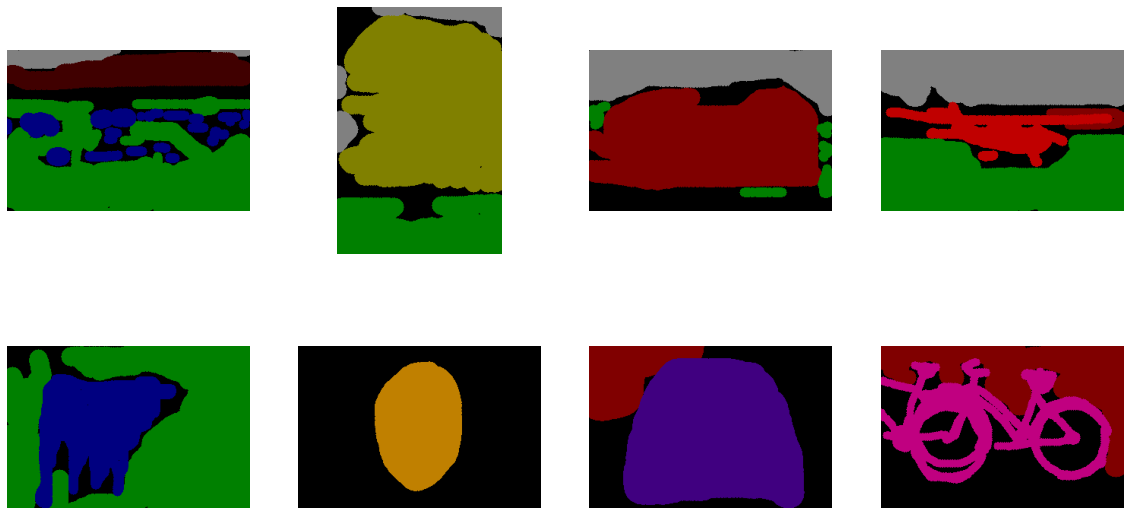

In [ ]:
path = '/content/MSRC_ObjCategImageDatabase_v1'
image1_GT = imageio.imread(os.path.join(path,'1_10_s_GT.bmp'))
image2_GT = imageio.imread(os.path.join(path,'2_10_s_GT.bmp'))
image3_GT = imageio.imread(os.path.join(path,'3_10_s_GT.bmp'))
image4_GT = imageio.imread(os.path.join(path,'4_10_s_GT.bmp'))
image5_GT = imageio.imread(os.path.join(path,'5_10_s_GT.bmp'))
image6_GT = imageio.imread(os.path.join(path,'6_10_s_GT.bmp'))
image7_GT = imageio.imread(os.path.join(path,'7_10_s_GT.bmp'))
image8_GT = imageio.imread(os.path.join(path,'8_10_s_GT.bmp'))

F, ax = plt.subplots(2,4, figsize=(20,10))
ax[0,0].imshow(image1_GT)
ax[0,0].axis('off')
ax[0,1].imshow(image2_GT)
ax[0,1].axis('off')
ax[0,2].imshow(image3_GT)
ax[0,2].axis('off')
ax[0,3].imshow(image4_GT)
ax[0,3].axis('off')
ax[1,0].imshow(image5_GT)
ax[1,0].axis('off')
ax[1,1].imshow(image6_GT)
ax[1,1].axis('off')
ax[1,2].imshow(image7_GT)
ax[1,2].axis('off')
ax[1,3].imshow(image8_GT)
ax[1,3].axis('off')

plt.show()

# Ncut Analysis
Below is defined the main function to obtain both the initial superpixels of the image and the final segmentation using Ncut.\
I used the SLIC algorithm in the skimage library. It creates miniclusters using the kmeans algorythm in the x-y-color space. I selected this algorithm for the initial segmentation in superpixels because is the one (w.r.t. Felzenszwalbs, Quickshift and Watershed) more transparent to understand, it is both color and space proximity based and create superpixel with simple shapes that let us see more clearly the effects of the ncut algorithm.\
Then I used the rag_mean_color function to generate the graph. The mode is set to similarity, so that the more similar two superpixel are, the higher is the value of the edge that links them. Finally we apply the ncut.

In [ ]:
def apply_slic(image, n_segments, compactness, sigma, sigma_rag, thresh, scale=100):
  # Segment the image
  image_segmentation = segmentation.slic(image, n_segments=n_segments, compactness=compactness, sigma=sigma, start_label=1, enforce_connectivity=True)
  # Image marked with the superpixels
  marked = segmentation.mark_boundaries(image, image_segmentation)

  # Create the graph
  g = graph.rag_mean_color(image, image_segmentation, mode='similarity', sigma=sigma_rag)
  # Segment
  segmentation_ncut = graph.cut_normalized(image_segmentation, g, thresh=thresh)
  out = color.label2rgb(segmentation_ncut, image, kind='avg', bg_label=0)/255
  return out, segmentation_ncut, image_segmentation, marked

## Parameters Analysis
First we look at the parameters related to the initial superpixel segmentation SLIC:

*   n_segments: the approximate number of superpixels in the image. Going over 200 didn't give any advantage. As you can see in the marked pictures below the images are well superpixeled and most of the patterns or objects are good segmented. Boundary also follow in a good manner the limits of the objects
*   compactness: defines how the algorithms weights space similarity and color similarity. A higher value is more space-similarity bounded and generates superpixels that look more like squares. Going low on this parameters puts higher importance in color matching but generates superpixels with strange shapes.
*   sigma: the algorithm starts by smoothing the image with a gaussian kernel. It helps the image not to get strange superpixels shapes and to not give too much segmentation from the color shades.

For the rag_mean_color function we have only one parameter:
*   sigma_rag: since the affinity of two superpixels is defined as exp(-d^2/sigma_rag) where d is the euclidean distance between two pixels, a high value of this parameter makes different colors behave more similarly. Default was 255, I preferred to lower it.

Finally we have a parameter for the ncut function:
*   thresh: edges with higher affinity than this value won't be cutted (best combination I found is with its default value).



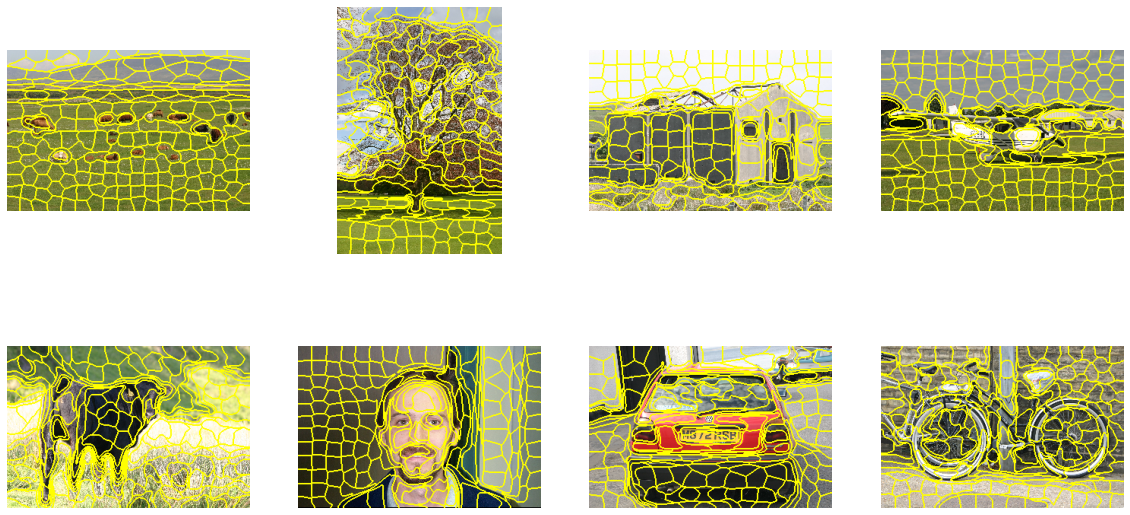

In [ ]:
n_segments = 200
compactness = 5
sigma = 4
sigma_rag = 100.
thresh = 0.001
image1_ncut, image1_ncut_segmentation, _, image1_marked = apply_slic(image1, n_segments=n_segments, compactness=compactness, sigma=sigma, sigma_rag=sigma_rag, thresh=thresh)
image2_ncut, image2_ncut_segmentation, _, image2_marked = apply_slic(image2, n_segments=n_segments, compactness=compactness, sigma=sigma, sigma_rag=sigma_rag, thresh=thresh)
image3_ncut, image3_ncut_segmentation, _, image3_marked = apply_slic(image3, n_segments=n_segments, compactness=compactness, sigma=sigma, sigma_rag=sigma_rag, thresh=thresh)
image4_ncut, image4_ncut_segmentation, _, image4_marked = apply_slic(image4, n_segments=n_segments, compactness=compactness, sigma=sigma, sigma_rag=sigma_rag, thresh=thresh)
image5_ncut, image5_ncut_segmentation, _, image5_marked = apply_slic(image5, n_segments=n_segments, compactness=compactness, sigma=sigma, sigma_rag=sigma_rag, thresh=thresh)
image6_ncut, image6_ncut_segmentation, _, image6_marked = apply_slic(image6, n_segments=n_segments, compactness=compactness, sigma=sigma, sigma_rag=sigma_rag, thresh=thresh)
image7_ncut, image7_ncut_segmentation, _, image7_marked = apply_slic(image7, n_segments=n_segments, compactness=compactness, sigma=sigma, sigma_rag=sigma_rag, thresh=thresh)
image8_ncut, image8_ncut_segmentation, _, image8_marked = apply_slic(image8, n_segments=n_segments, compactness=compactness, sigma=sigma, sigma_rag=sigma_rag, thresh=thresh)

F, ax = plt.subplots(2,4, figsize=(20,10))
ax[0,0].imshow(image1_marked)
ax[0,0].axis('off')
ax[0,1].imshow(image2_marked)
ax[0,1].axis('off')
ax[0,2].imshow(image3_marked)
ax[0,2].axis('off')
ax[0,3].imshow(image4_marked)
ax[0,3].axis('off')
ax[1,0].imshow(image5_marked)
ax[1,0].axis('off')
ax[1,1].imshow(image6_marked)
ax[1,1].axis('off')
ax[1,2].imshow(image7_marked)
ax[1,2].axis('off')
ax[1,3].imshow(image8_marked)
ax[1,3].axis('off')

plt.show()

As we can see the images with these parameters are well segmented into subpixels that follow the shades of colors and identify somewhat correctly objecs (for example the animals in the first images and the facial features of the sixth image). The last image is also well segmented even if the colors of the bike are very similar to the surrounding. Now let's have a look at the final segmentation of these images after NCut is applied

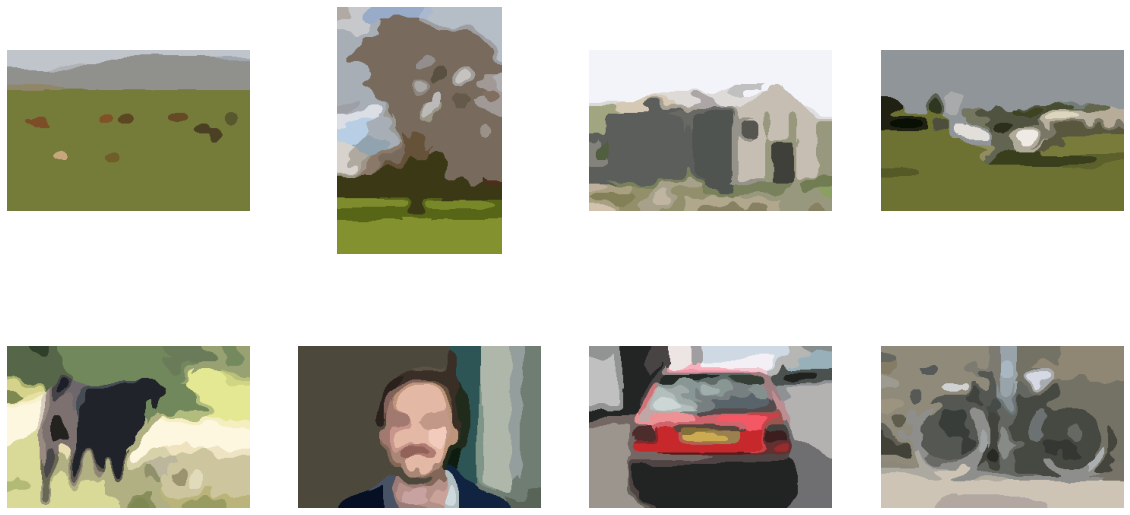

In [ ]:
F, ax = plt.subplots(2,4, figsize=(20,10))
ax[0,0].imshow(image1_ncut)
ax[0,0].axis('off')
ax[0,1].imshow(image2_ncut)
ax[0,1].axis('off')
ax[0,2].imshow(image3_ncut)
ax[0,2].axis('off')
ax[0,3].imshow(image4_ncut)
ax[0,3].axis('off')
ax[1,0].imshow(image5_ncut)
ax[1,0].axis('off')
ax[1,1].imshow(image6_ncut)
ax[1,1].axis('off')
ax[1,2].imshow(image7_ncut)
ax[1,2].axis('off')
ax[1,3].imshow(image8_ncut)
ax[1,3].axis('off')

plt.show()

As we can see in all images results are not bad and in most of them the 
algorithms were able to segment the images in a good way without keeping too many different shades of colors

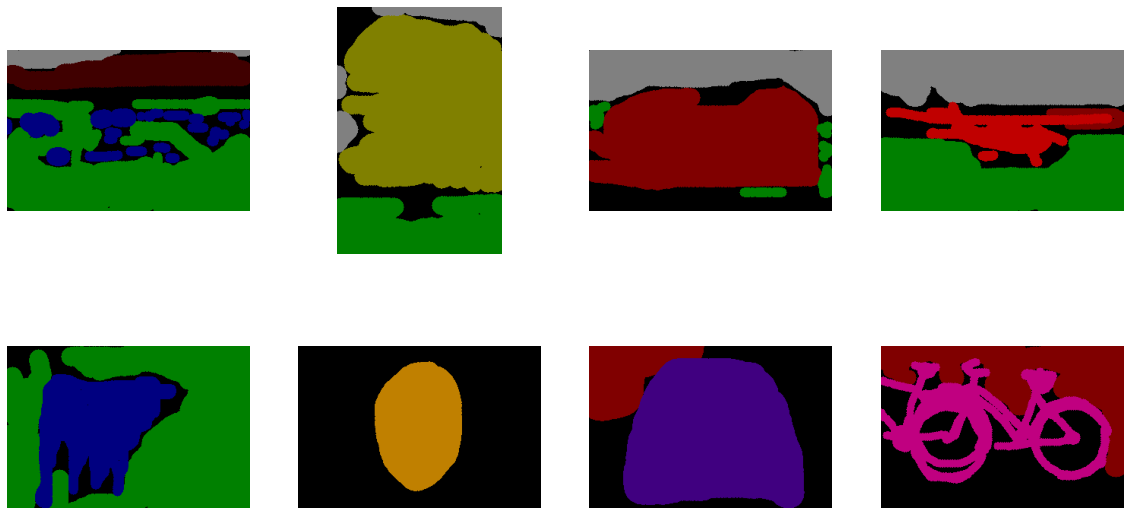

In [ ]:
F, ax = plt.subplots(2,4, figsize=(20,10))
ax[0,0].imshow(image1_GT)
ax[0,0].axis('off')
ax[0,1].imshow(image2_GT)
ax[0,1].axis('off')
ax[0,2].imshow(image3_GT)
ax[0,2].axis('off')
ax[0,3].imshow(image4_GT)
ax[0,3].axis('off')
ax[1,0].imshow(image5_GT)
ax[1,0].axis('off')
ax[1,1].imshow(image6_GT)
ax[1,1].axis('off')
ax[1,2].imshow(image7_GT)
ax[1,2].axis('off')
ax[1,3].imshow(image8_GT)
ax[1,3].axis('off')

plt.show()

# Metrics discussion
Recall Intersection over Union metric: it is calculated as the area of intersection of two subsets of the image divided by the union of the two. It tells us how precise our method is at finding objects or pattern with respect to a ground truth. Note that for obtaining a good score our prediction should match the ground truth segments without going outside, overlapping perfectly.
## First metric - Intersection over Union aggregate
The first metric we are going to consider a version of Intersection over union in which I tried to compensate some of the problems I encountered:


1.   I needed to create a metric that was color invariant: matching the label target colors of the ground truth based only on the images was not doable (unless using some prediction or learning algorithm). In this case the IoU aggregate simply sums the IoU contributions of each possible couple color_in_GT-color_in_image so that the actual colors used are not important.
2.   The semantic segments are more than one (we are not trying to identify a precise object, but different segments in the same pictures).

The metric is defined as follows: for each color in the ground truth image and for each color in the segmented image we calculate the IntersectionOverUnion metric of the areas in those colors and some all the contributes over all couples. We finally divide the result by the total number of colors in the ground truth image (in this way we penalize if the segmented image is segmented in too many colors).



1.   Note that if a semantic segment of a ground truth image is exactly partitioned into k segments then the total contribution is the same as if the algorithm doesn't partition it and output correctly the whole semantic segment
2.   The maximum possible outcome is 1, this happens when all segments of the ground truth are perfectly partitioned without overlapping of our predicted ones with more than one ground truth segments.

This metrics mainly focuses on how good is our method at segmenting the image into the right shapes, without putting attention on how the code is able to distinguish an object as a whole.





In [ ]:
def IoUaggregate(GT, image):
  # Flatten the image in a vector of dimension (len*width, 3) so that it is easier to operate on things
  image_flat = image.reshape((-1, image.shape[2]))
  GT_flat = GT.reshape((-1, GT.shape[2]))

  # Now get the unique colors in the images
  image_unique_colors = np.unique(image_flat, axis=0)
  GT_unique_colors = np.unique(GT_flat, axis=0)

  result = 0.
  # Now we calculate the metric for each couple of unique colors
  for color_im in image_unique_colors:
    for color_GT in GT_unique_colors:
      detected_im = np.where((image_flat == color_im).all(axis=1))
      detected_GT = np.where((GT_flat == color_GT).all(axis=1))

      intersect = np.intersect1d(detected_im, detected_GT).shape[0]
      union = np.union1d(detected_im, detected_GT).shape[0]
      result = result + float(intersect)/float(union)
  result = result/GT_unique_colors.shape[0]
  return result

## Second metric - Intersection over Union pairing
This second metric is another modified version of the Intersection over union metric. In this case for each target colored area of the ground truth image we try to match it with every color of our segmentation. We consider only the one that gives the best IoU metric. The final result is the sum of this single contributions over the labels in the ground truth image. divided by the total number of labels in the ground truth as before. We are therefore trying to force a perfect color-color matching rejecting object partitioning.


1.   Just like before, the optimal scenario gives a score of 1.
2.   In this case we are actually focusing more on identifying objects on the whole, considering only the segments that better overlap with the targets.

## Third metric
The third metric we will consider is just the mean of the two mentioned before.
This is meant to be a good compromise between segmenting correctly the image and finding the exact segments of the ground truth.



In [ ]:
def IoUpairing(GT, image):
  # Flatten the image in a vector of dimension (len*width, 3) so that it is easier to operate on things
  image_flat = image.reshape((-1, image.shape[2]))
  GT_flat = GT.reshape((-1, GT.shape[2]))

  # Now get the unique colors in the images
  image_unique_colors = np.unique(image_flat, axis=0)
  GT_unique_colors = np.unique(GT_flat, axis=0)
  result = 0.
  for color_GT in GT_unique_colors:
    best = 0.
    for color_im in image_unique_colors:
      detected_im = np.where((image_flat == color_im).all(axis=1))
      detected_GT = np.where((GT_flat == color_GT).all(axis=1))
      intersect = np.intersect1d(detected_im, detected_GT).shape[0]
      union = np.union1d(detected_im, detected_GT).shape[0]
      iou = float(intersect)/float(union)
      if iou > best:
        best = iou
    result = result + best
  return result/GT_unique_colors.shape[0]

IoUpairing metric evaluation for the images we selected

In [ ]:
print('Image 1: {}'.format(IoUpairing(image1_GT, image1_ncut)))
print('Image 2: {}'.format(IoUpairing(image2_GT, image2_ncut)))
print('Image 3: {}'.format(IoUpairing(image3_GT, image3_ncut)))
print('Image 4: {}'.format(IoUpairing(image4_GT, image4_ncut)))
print('Image 5: {}'.format(IoUpairing(image5_GT, image5_ncut)))
print('Image 6: {}'.format(IoUpairing(image6_GT, image6_ncut)))
print('Image 7: {}'.format(IoUpairing(image7_GT, image7_ncut)))
print('Image 8: {}'.format(IoUpairing(image8_GT, image8_ncut)))


Image 1: 0.4866141644501408
Image 2: 0.4664279714022599
Image 3: 0.37824806391742927
Image 4: 0.4279249277414562
Image 5: 0.2709778665960992
Image 6: 0.3622365757629612
Image 7: 0.2897913980077324
Image 8: 0.2508240369844299


IoUaggregate metric evaluation: as we can see the results for this metric are much better, in some cases even too high for our objectives.

In [ ]:
print('Image 1: {}'.format(IoUaggregate(image1_GT, image1_ncut)))
print('Image 2: {}'.format(IoUaggregate(image2_GT, image2_ncut)))
print('Image 3: {}'.format(IoUaggregate(image3_GT, image3_ncut)))
print('Image 4: {}'.format(IoUaggregate(image4_GT, image4_ncut)))
print('Image 5: {}'.format(IoUaggregate(image5_GT, image5_ncut)))
print('Image 6: {}'.format(IoUaggregate(image6_GT, image6_ncut)))
print('Image 7: {}'.format(IoUaggregate(image7_GT, image7_ncut)))
print('Image 8: {}'.format(IoUaggregate(image8_GT, image8_ncut)))


Image 1: 0.584962212185643
Image 2: 0.887845381344713
Image 3: 0.8515485680218983
Image 4: 0.8379763255465644
Image 5: 0.8603496215556055
Image 6: 0.9570056005427054
Image 7: 0.973169547558141
Image 8: 0.9181259349698307


## Dataset analysis
Here we import all the images

In [ ]:
filelist = sorted(glob.glob(os.path.join(path, '*s.bmp')))
images = np.array([np.array(imageio.imread(fname)) for fname in filelist], dtype=object)

Now we import the ground truth images

In [ ]:
filelist = sorted(glob.glob(os.path.join(path, '*s_GT.bmp')))
images_GT = np.array([np.array(imageio.imread(fname)) for fname in filelist], dtype=object)

Define the function for elaborating images and metrics

In [ ]:
def get_IoUmetrics(GT, image):
  image_ncut, _, _, _ = apply_slic(image, n_segments=n_segments, compactness=compactness, sigma=sigma, sigma_rag=sigma_rag, thresh=thresh)

  agg = IoUaggregate(GT, image_ncut)
  pair = IoUpairing(GT, image_ncut)

  return image_ncut, np.mean([agg, pair]), agg, pair


## Metrics calculations over the dataset
Now we perform calculations on all the images. Unfortunately some images with this parameters do not converge or give errors (14 over 240 images) so I decided to avoid them.

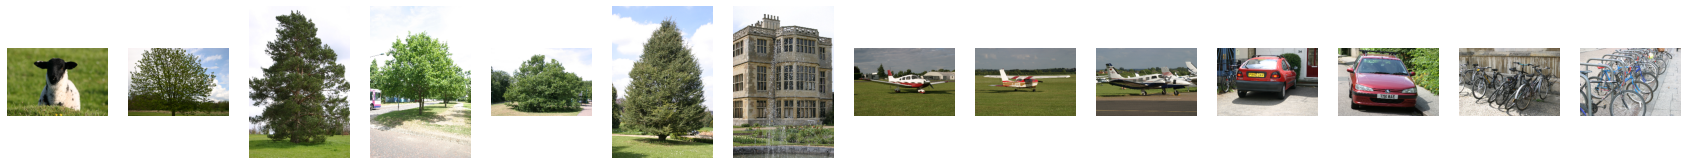

In [ ]:
to_avoid = [18, 36, 41, 46, 47, 56, 81, 91, 107, 116, 194, 199, 224, 230]
F, ax = plt.subplots(1,len(to_avoid),figsize=(30,10))
for i, toa in enumerate(to_avoid):
  ax[i].imshow(images[toa])
  ax[i].axis('off')


In [ ]:
to_avoid = [18, 36, 41, 46, 47, 56, 81, 91, 107, 116, 194, 199, 224, 230]
np.random.seed(42)
image_metrics = np.zeros((images.shape[0], 4))
image_metrics[:,3] = np.arange(240)
images_ncuts = np.copy(images)
tot_images = images.shape[0]
for i, image in enumerate(images):
  #print('Image {} of {}'.format(i+1, tot_images))
  if i not in to_avoid:
    ncut, a, b, c = get_IoUmetrics(images_GT[i], images[i])
    images_ncuts[i] = ncut
    image_metrics[i,0:3] = np.array([a,b,c])
  else:
    image_metrics[i,0:3] = np.array([-1,-1,-1])

Mean results for the three metrics (IoUmean - IoUaggregate - IoUpairing)

In [ ]:
print(np.mean(image_metrics, axis=0))

[  0.52419492   0.72719858   0.32119126 119.5       ]


## Results analysis
Now we look at 3 of the best and worst examples for each metric. Notice I didn't select exactly the best and worst examples for each metric, as most of them (expecially for the best ones) are similar images from the same thematic dataset.\
I instead preferred to select some examples that are more interesting to analize individually.

In [ ]:
image_metrics_mean = np.copy(image_metrics)
image_metrics_mean = image_metrics_mean[image_metrics_mean[:,0].argsort()]
#print(image_metrics_mean)
worst_mean = [115, 5, 145]
best_mean = [64, 24, 50]

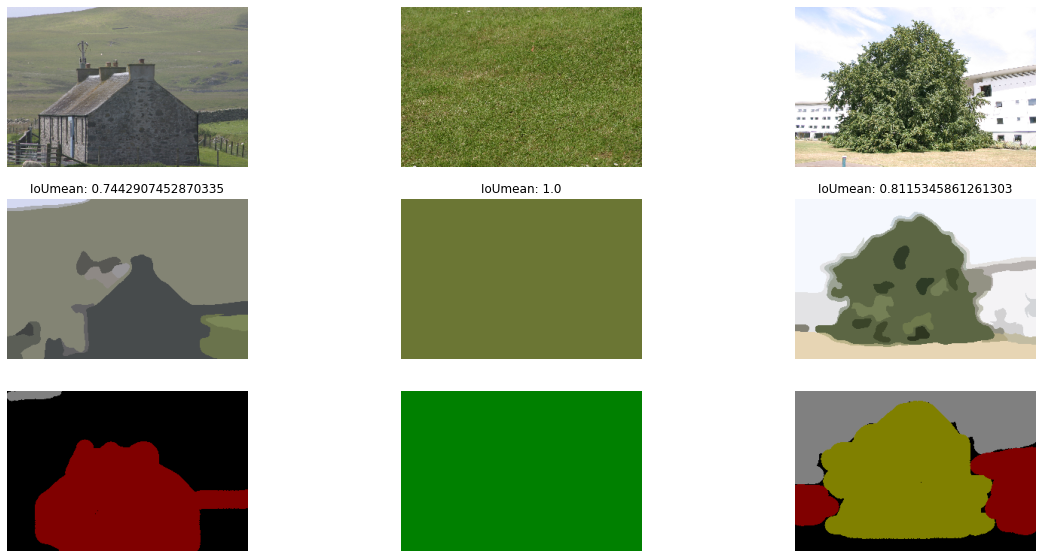

In [ ]:
F, ax = plt.subplots(3,3,figsize=(20,10))
for i, ind in enumerate(worst_mean):
  ax[0, i].imshow(images[ind])
  ax[0, i].axis('off')
  ax[1, i].imshow(images_ncuts[ind])
  ax[1, i].axis('off')
  ax[1, i].set_title('IoUmean: {}'.format(image_metrics[ind,0]))
  ax[2, i].imshow(images_GT[ind])
  ax[2, i].axis('off')

F, ax = plt.subplots(3,3,figsize=(20,10))
for i, ind in enumerate(best_mean):
  ax[0, i].imshow(images[ind])
  ax[0, i].axis('off')
  ax[1, i].imshow(images_ncuts[ind])
  ax[1, i].axis('off')
  ax[1, i].set_title('IoUmean: {}'.format(image_metrics[ind,0]))
  ax[2, i].imshow(images_GT[ind])
  ax[2, i].axis('off')

Let's first look at the first three images, taken from the worst results in the IoUmean metric:


*   In the first image, the colors of the airpane and the sky are very similar. The algorithm is not able to distinguish them in a good manner and this leads to a poor segmentation: both the aggregate and the pairing metrics suffer from this behaviour.
*   The second and the third image present the same problem: due to a lot of shadows and different characteristics of the animals the images are too much segmented with respect to the ground truth: the IoUpairing metric gives bad scores and the partitioning is also bad giving a bad IoUaggreate metric as well.

Now let's look at the 3 images taken from the best:


1.   In the first one the parameters we choose are sufficient to smooth the image enough to not have too much segmentation in the image, maintaining good resuls. The background covers also a good portion of the image, so that this gets recognized well (even if a part of the house gets included as part of the background by the algorithm).
2.   The second image is pretty clear: there is not much to segment and our smoothing works well. This gets a perfect score.
3.   In the third image the colors of the four ground truth images are well distinguishable or well separated (for examples the roof divides the walls from the sky) and this leads to a good segmentation. The colors in the original image are also uniform so that we don't have too much segmentation or partitioning.





In [ ]:
image_metrics_agg = np.copy(image_metrics)
image_metrics_agg = image_metrics_agg[image_metrics_agg[:,1].argsort()]
print(image_metrics_agg)
worst_agg = [115, 5, 145]
best_agg = [24, 168, 214]

[[-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  4.10000000e+01]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  2.24000000e+02]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  8.10000000e+01]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  2.30000000e+02]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  9.10000000e+01]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  1.16000000e+02]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  1.80000000e+01]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  1.99000000e+02]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  4.60000000e+01]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  5.60000000e+01]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  1.94000000e+02]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  4.70000000e+01]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  3.60000000e+01]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  1.07000000e+02]
 [ 1.73266007e-01  1.80213267e-01  1.66318747e-01  1.14000000e

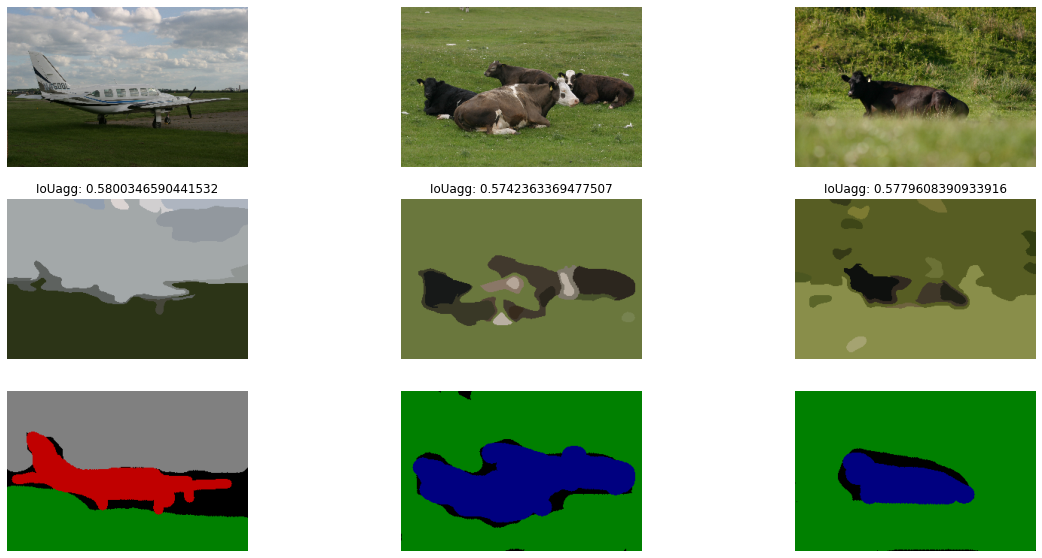

In [ ]:
F, ax = plt.subplots(3,3,figsize=(20,10))
for i, ind in enumerate(worst_agg):
  ax[0, i].imshow(images[ind])
  ax[0, i].axis('off')
  ax[1, i].imshow(images_ncuts[ind])
  ax[1, i].axis('off')
  ax[1, i].set_title('IoUagg: {}'.format(image_metrics[ind,1]))
  ax[2, i].imshow(images_GT[ind])
  ax[2, i].axis('off')

F, ax = plt.subplots(3,3,figsize=(20,10))
for i, ind in enumerate(best_agg):
  ax[0, i].imshow(images[ind])
  ax[0, i].axis('off')
  ax[1, i].imshow(images_ncuts[ind])
  ax[1, i].axis('off')
  ax[1, i].set_title('IoUagg: {}'.format(image_metrics[ind,1]))
  ax[2, i].imshow(images_GT[ind])
  ax[2, i].axis('off')

Let's now look at the best and worst images for the aggregate metric, starting from the worst ones:


*   The images are the same as before: in the first case the airplane gets included into the sky, in the second and third one we see that in both cases some parts of the animals are included in the segments from the grass.

About the best images:



1.   Same as before: no need to segment the image and the smoothing works well.
2.   The second image is very interesting: there are lots of objects with different colors. The image gets very segmented and the object are still distinguishable. The ground truth segments get partitioned into a lot of small superpixels (we will see that for the pairing metric this is bad) but for the aggregate metric this is still good.
3.   This example is similar to the previous one: lots of colors, lot of segmentation, aggregation is still good.





In [ ]:
image_metrics_pair = np.copy(image_metrics)
image_metrics_pair = image_metrics_pair[image_metrics_pair[:,2].argsort()]
#print(image_metrics_pair)
worst_pair = [132, 168, 234]
best_pair = [10, 64, 193]

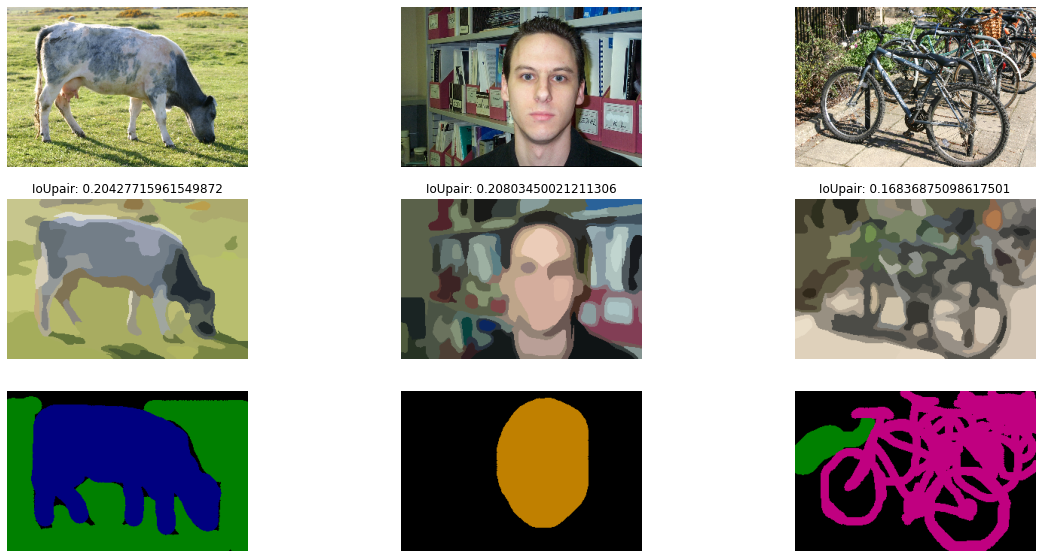

In [ ]:
F, ax = plt.subplots(3,3,figsize=(20,10))
for i, ind in enumerate(worst_pair):
  ax[0, i].imshow(images[ind])
  ax[0, i].axis('off')
  ax[1, i].imshow(images_ncuts[ind])
  ax[1, i].axis('off')
  ax[1, i].set_title('IoUpair: {}'.format(image_metrics[ind,2]))
  ax[2, i].imshow(images_GT[ind])
  ax[2, i].axis('off')

F, ax = plt.subplots(3,3,figsize=(20,10))
for i, ind in enumerate(best_pair):
  ax[0, i].imshow(images[ind])
  ax[0, i].axis('off')
  ax[1, i].imshow(images_ncuts[ind])
  ax[1, i].axis('off')
  ax[1, i].set_title('IoUpair: {}'.format(image_metrics[ind,2]))
  ax[2, i].imshow(images_GT[ind])
  ax[2, i].axis('off')

Finally we look at the pairing metric results, starting from the worst ones:


1.   In the first image, we still have a good idea of the forms of the objects but the abundancy of colors and features in the grass and in the animal lead to too much segmentation so that when the metric function pairs the colors, they all lead to a bad score individually.
2.   The second image is the same as before. We have too much colors, objects and shades: the image gets segmented too much.
3.   The third example is similar: too much segmentation.

For the best examples:


1.   The first image is simlilar to the previous best examples in the grass thematic images: in this case some flowers managed to break the perfect score. The final result is very good because 99% of the image has the same color.
2.   We have already seen this image: some parts of the house get included into the background but the majority of it and the other segments are very uniform in color and this leads to a good pairing of the segments.
3.   In this last example the car gets segmented too much, but the uniformity in color of the car body itself, of the walls and the ground lead to not too much partitioning and segmentation.





# Final conclusions
I worked on three metrics:

*   The aggregate metric mainly indicates how well object boundaries are identified in the segmentation. It gives good scores to images that don't lose the object bounds even if it gets too much partitioned.
*   The pairing metric is the most precise one: getting a perfect score in this ensures that the image is perfectly segmented into the ground truth segments. It penalizes a lot the partitioning of objects and this is the main difficulty with this metric with our examples.
*   The IoUmain metric is the mean of the two before. It averages well the ability of an algorithm to not break object boundaries and the ability of recognizing the correct ground truth segments that represent the semantics as a whole. This is in my opionion the best metric to look at with just this tools.

With just these tools, I don't think we can obtain much better results on all possible kind of images. Some of them (expecially those with faces and books on the background) are really hard to segment by just considering similarities in the x-y-color space without feeding any other information. A possibility could be applying some kind of filters to the segmented image, in order to distinguish patterns corresponding to the ones in the ground truth.

